In [101]:
import torch
import torch.nn as nn


class customLoss(nn.Module):
    def __init__(self, weight):
        # --------------------------------------------
        # Initialization
        # --------------------------------------------
        super(customLoss, self).__init__()
        self.softmax = nn.Softmax(dim=1)
        self.weight = weight

    def forward(self, outputs, targets):
        # --------------------------------------------
        # Define forward pass
        # --------------------------------------------
        # Transform targets to one-hot vector
        targets_onehot = torch.zeros_like(outputs)
        targets_onehot.zero_()
        targets_onehot.scatter_(1, targets.unsqueeze(-1), 1)

        # nn.CrossEntropyLoss combines nn.LogSoftmax() and nn.NLLLoss()
        outputs = self.softmax(outputs)
        self.weight = self.weight.expand_as(outputs)
        loss = -targets_onehot.float() * torch.log(outputs)
        return torch.mean(self.weight * loss)


# Define CrossEntropyLoss with weights
weight = torch.Tensor([1, 5, 10])

# Define inputs, official and custom loss
outputs = torch.Tensor([[0.9, 0.5, 0.05], [0.01, 0.2, 0.7]])
targets = torch.Tensor([0, 1]).long()
criterion = nn.CrossEntropyLoss(weight=weight)
custom_criterion = customLoss(weight=weight)

# Compare losses
loss = criterion(outputs, targets)
custom_loss = custom_criterion(outputs, targets)
print('official loss: ', loss.item())
print('custom loss:   ', custom_loss.item())

In [102]:
loss_function = nn.BCELoss(weight=torch.tensor([[1.], [1.], [1.]]))
outputs = torch.tensor([[1.],
        [0.],
        [0.]], requires_grad=True)
targets = torch.tensor([[0.],
        [0.],
        [0.]])
loss_function(outputs, targets)

tensor(33.3333, grad_fn=<BinaryCrossEntropyBackward0>)

In [103]:
import torch
import torch.nn as nn


loss_function = nn.BCELoss(weight=torch.tensor([[2.], [1.], [1.]]))
outputs = torch.tensor([[[0.1582, 0.8477],
         [0.1691, 0.8357],
         [0.1689, 0.8360]]],requires_grad=True)
targets = torch.tensor([[[0., 1.],
         [0., 1.],
         [1., 0.]]])
loss_function(outputs, targets)

tensor(0.7710, grad_fn=<BinaryCrossEntropyBackward0>)

In [104]:
import torch
import torch.nn as nn


loss_function = nn.BCELoss(weight=torch.tensor([[1.], [1.], [1.]]))
outputs = torch.tensor([[[1., 0.],
         [1., 0.],
         [1., 0.]]],requires_grad=True)
targets = torch.tensor([[[0., 1.],
         [0., 1.],
         [1., 0.]]])
loss_function(outputs, targets)

tensor(66.6667, grad_fn=<BinaryCrossEntropyBackward0>)

In [105]:
torch.randn(3, 1, requires_grad=True)

tensor([[ 1.1039],
        [-0.1343],
        [-2.5171]], requires_grad=True)

In [106]:
torch.empty(3, 1).random_(2)

tensor([[1.],
        [0.],
        [0.]])

In [107]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)
set_seed(42)

# with open('parameters.json', 'r') as file:
#     params = json.load(file)

In [108]:
params = {
    "start_date": "2001-01-01",
    "stop_date": "2021-01-01",
    "stock_symbol": "^GSPC",
    "features_params": [
        {"type": "Trend", "method": "MA", "oder_days": 20,
         "ma_days": 10, "trend_days": 5},
        {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
        {"type": "ROC", "trend_days": 5},
        {"type": "Stochastic Oscillator", "trend_days": 5},
        {"type": "CCI", "timeperiod": 14},
        {"type": "RSI", "timeperiod": 14},
        {"type": "VMA", "timeperiod": 20},
        {"type": "PctChange"},
        {"type": "3M Treasury Yield", "start_date": "2001-01-01",
            "end_date": "2021-01-01"},
        {"type": "5Y Treasury Yield", "start_date": "2001-01-01",
            "end_date": "2021-01-01"},
        {"type": "10Y Treasury Yield",
            "start_date": "2001-01-01", "end_date": "2021-01-01"},
        {"type": "30Y Treasury Yield",
            "start_date": "2001-01-01", "end_date": "2021-01-01"}
    ],
    "data_cleaning": {
        "clean_type": "MissingData", 
        "strategy": "auto"
    },
    "split_ratio": 0.7,
    "target_col": "Trend",
    "feature_cols": [
        "MACD", "ROC", "CCI", "RSI", "VMA",
        "3M Treasury Yield", "5Y Treasury Yield",
        "10Y Treasury Yield", "30Y Treasury Yield"
    ],
    "look_back": 32,
    "predict_steps": 8,
    "train_slide_steps": 1,
    "test_slide_steps": 8,
    "model_params": {
        "LeNet": {
            "look_back": 32,
            "predict_steps": 8,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 8,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "fc_1_out_features": 512,
            "reshape": "False"
        },
        "LeNet_2": {
            "look_back": 32,
            "predict_steps": 8,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 6,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "conv_2_out_channels": 8,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool2d_2_kernel_size": 2,
            "fc_1_out_features": 512,
            "reshape": "False"
        },
        "RNN": {
            "look_back": 32,
            "predict_steps": 8,
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        },
        "LSTM": {
            "look_back": 32,
            "predict_steps": 8,
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        },
        "CNN_LSTM": {
            "look_back": 32,
            "predict_steps": 8,
            "conv_1_in_channels": 19,
            "conv_1_out_channels": 6,
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool2d_1_kernel_size": 2,
            "conv_2_out_channels": 8,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool2d_2_kernel_size": 2,
            "fc_1_out_features": 512,
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2,
            "reshape": "False"
        }
    },
    "model_type" : "LeNet",
    "training_epoch_num": 1000,
    "online_training_epoch_num": 10,
    "learning_rate": 0.001,
    "filter": 10
  }
  

In [109]:
# params = {
#     "start_date": "2001-01-01",
#     "stop_date": "2021-01-01",
#     "stock_symbol": "^GSPC",
#     "features_params": [
#         {"type": "Trend", "method": "LocalExtrema", "oder_days": 20,
#          "ma_days": 20, "trend_days": 5},
#         {"type": "MACD", "fastperiod": 5, "slowperiod": 10, "signalperiod": 9},
#         {"type": "ROC", "trend_days": 5},
#         {"type": "Stochastic Oscillator", "trend_days": 5},
#         {"type": "CCI", "timeperiod": 14},
#         {"type": "RSI", "timeperiod": 14},
#         {"type": "VMA", "timeperiod": 20},
#         {"type": "PctChange"},
#         {"type": "3M Treasury Yield", "start_date": "2001-01-01",
#             "end_date": "2021-01-01"},
#         {"type": "5Y Treasury Yield", "start_date": "2001-01-01",
#             "end_date": "2021-01-01"},
#         {"type": "10Y Treasury Yield",
#             "start_date": "2001-01-01", "end_date": "2021-01-01"},
#         {"type": "30Y Treasury Yield",
#             "start_date": "2001-01-01", "end_date": "2021-01-01"}
#     ],
#     "data_cleaning": {
#         "clean_type": "MissingData", 
#         "strategy": "auto"
#     },
#     "split_ratio": 0.7,
#     "target_col": "Trend",
#     "feature_cols": [
#         "MACD", "ROC", "CCI", "RSI", "VMA", 
#         "3M Treasury Yield", "5Y Treasury Yield",
#         "10Y Treasury Yield", "30Y Treasury Yield"
#     ],
#     "look_back": 64,
#     "predict_steps": 16,
#     "train_slide_steps": 1,
#     "test_slide_steps": 16,
#     "model_params": {
#         "LeNet": {
#             "look_back": 64,
#             "predict_steps": 16,
#             "conv_1_in_channels": 19,
#             "conv_1_out_channels": 16,
#             "conv_1_kernel": 3,
#             "conv_1_padding": 1,
#             "MaxPool2d_1_kernel_size": 2,
#             "fc_1_out_features": 512,
#             "reshape": "False"
#         },
#         "LeNet_2": {
#             "look_back": 64,
#             "predict_steps": 16,
#             "conv_1_in_channels": 19,
#             "conv_1_out_channels": 6,
#             "conv_1_kernel": 3,
#             "conv_1_padding": 1,
#             "MaxPool2d_1_kernel_size": 2,
#             "conv_2_out_channels": 16,
#             "conv_2_kernel": 3,
#             "conv_2_padding": 1,
#             "MaxPool2d_2_kernel_size": 2,
#             "fc_1_out_features": 512,
#             "reshape": "False"
#         },
#         "RNN": {
#             "look_back": 64,
#             "predict_steps": 16,
#             "hidden_size": 64,
#             "num_layers": 1,
#             "dropout": 0.2,
#             "reshape": "False"
#         },
#         "LSTM": {
#             "look_back": 64,
#             "predict_steps": 16,
#             "hidden_size": 64,
#             "num_layers": 1,
#             "dropout": 0.2,
#             "reshape": "False"
#         },
#         "CNN_LSTM": {
#             "look_back": 64,
#             "predict_steps": 16,
#             "conv_1_in_channels": 19,
#             "conv_1_out_channels": 6,
#             "conv_1_kernel": 3,
#             "conv_1_padding": 1,
#             "MaxPool2d_1_kernel_size": 2,
#             "conv_2_out_channels": 16,
#             "conv_2_kernel": 3,
#             "conv_2_padding": 1,
#             "MaxPool2d_2_kernel_size": 2,
#             "fc_1_out_features": 512,
#             "hidden_size": 64,
#             "num_layers": 1,
#             "dropout": 0.2,
#             "reshape": "False"
#         }
#     },
#     "model_type" : "LeNet",
#     "training_epoch_num": 1000,
#     "online_training_epoch_num": 10,
#     "learning_rate": 0.001,
#     "filter": 10
#   }
  

In [110]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data(params['stock_symbol'], params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data,
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_SP, y_train_SP, X_test, y_test, train_dates, test_dates = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'],
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'],
                            train_slide_steps=params['train_slide_steps'],
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


In [111]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data('^IXIC', params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data, 
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_NAS, y_train_NAS, _, _, train_dates_NAS, _ = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'], 
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'], 
                            train_slide_steps=params['train_slide_steps'], 
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 0 # up trend
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Trend'].iloc[i:i + trend_days] = 1 # down trend


In [ ]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data('^DJI', params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data, 
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_DJI, y_train_DJI, _, _, train_dates_DJI, _ = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'], 
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'], 
                            train_slide_steps=params['train_slide_steps'], 
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:91: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:88: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:98: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_pr

In [ ]:
preprocessor = Preprocessor()
data = preprocessor.fetch_stock_data('^RUT', params['start_date'], params['stop_date'])
for single_feature_params in params['features_params']:
    feature_type = single_feature_params["type"]
    data = preprocessor.add_feature(data, feature_type, **single_feature_params)
data, issues_detected = preprocessor.add_data_cleaner(data, 
    clean_type=params['data_cleaning']['clean_type'], strategy=params['data_cleaning']['strategy'])
X_train_RUT, y_train_RUT, _, _, train_dates_RUT, _ = \
    preprocessor.process_data(data, split_ratio=params['split_ratio'], target_col=params['target_col'], 
                            feature_cols=None, look_back=params['look_back'],
                            predict_steps=params['predict_steps'], 
                            train_slide_steps=params['train_slide_steps'], 
                            test_slide_steps=params['test_slide_steps'],
                            reshape=params['model_params'][params['model_type']]['reshape'])
X_newest, x_newest_date = preprocessor.create_x_newest_data(data, params['look_back'])


c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:91: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:88: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
c:\Users\e4903\Desktop\code\2023_hw\reverse_prediction\0127\project\preprocessor\preprocessor_pytorch.py:95: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
c:\Users\e4903\Desktop\code\2023_hw\reverse_pr

In [ ]:
import numpy as np

X_train_datasets = [X_train_SP, X_train_NAS, X_train_DJI, X_train_RUT]
y_train_datasets = [y_train_SP, y_train_NAS, y_train_DJI, y_train_RUT]
num_samples = min(len(X_train_SP), len(X_train_NAS), len(X_train_DJI), len(X_train_RUT))
# X_train_datasets = [X_train_SP]
# y_train_datasets = [y_train_SP]
# num_samples = len(X_train_SP)
data_len = len(X_train_datasets[0])

X_train_combined = []
y_train_combined = []
for i in tqdm.tqdm(range(num_samples)):
    for dataset in X_train_datasets:
        X_train_combined.append(dataset[i])
        y_train_combined.append(y_train_datasets[0][i])

X_train = torch.stack(X_train_combined, dim=0)
y_train = torch.stack(y_train_combined, dim=0)

# Randomly shuffle X_train and y_train in the same order
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

print(X_train.shape)


100%|██████████| 3470/3470 [00:00<00:00, 45463.80it/s]


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([13880, 32, 19]),
 torch.Size([13880, 8, 2]),
 torch.Size([184, 32, 19]),
 torch.Size([184, 8, 2]))

In [ ]:
y_train_original = y_train  

In [ ]:
y_train[0]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [ ]:
def apply_weights_to_tensor(tensor, weight_before=1, weight_after=2):
    # 初始化一個與原tensor形狀相同的權重tensor
    weights_tensor = torch.zeros_like(tensor)

    # 遍歷每個子tensor
    for idx, sub_tensor in enumerate(tensor):
        # 將子tensor轉換為numpy數組以方便處理
        array = sub_tensor.numpy()

        # 初始化子權重數組
        sub_weights = [weight_before] * len(array)

        # 尋找第一個轉折點
        for i in range(1, len(array)):
            if not (array[i] == array[i-1]).all():
                # 從第一個轉折點之後開始改變權重
                sub_weights[i:] = [weight_after] * (len(array) - i)
                break

        # 將子權重數組應用於每一行
        for j in range(len(sub_weights)):
            weights_tensor[idx, j] = torch.tensor([sub_weights[j]] * tensor.shape[2])

    return weights_tensor

# 計算權重
weights = apply_weights_to_tensor(y_train)
weights.shape


torch.Size([13880, 8, 2])

In [ ]:
# X_train = torch.transpose(X_train, 1, 2)
# X_test = torch.transpose(X_test, 1, 2)
# X_newest = torch.transpose(X_newest, 1, 2)
# y_train = torch.transpose(y_train, 1, 2)
# y_test = torch.transpose(y_test, 1, 2)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([13880, 32, 19]),
 torch.Size([13880, 8, 2]),
 torch.Size([184, 32, 19]),
 torch.Size([184, 8, 2]))

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train(model, X_train, y_train):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=3, min_delta=10)

    train_losses = []
    train_accuracy = []

    num_epochs = 1000
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        loss = loss_function(outputs, y_train)
        # backward pass and update weights
        loss.backward()
        optimizer.step()

        # calculate accuracy
        _, predicted = torch.max(outputs.data, -1)
        correct = (predicted == y_train.argmax(dim=-1)).sum().item()
        accuracy = correct / (y_train.size(-3)*y_train.size(-2))
        train_losses.append(loss.item())
        train_accuracy.append(accuracy)

        # early stopping based on training loss
        if early_stopper.early_stop(loss.item()):             
            break

    history = {
        'loss': train_losses,
        'binary_accuracy': train_accuracy
    }
    return history


def infer(model, X_test):
    y_pred = model(X_test)
    return y_pred

In [ ]:
def online_train(model, X_train, y_train, single_X_test, 
                    single_y_test, data_update_mode='newest'):
    # Update the training dataset with the new instance
    if data_update_mode == 'append':
        online_X_train = torch.cat((X_train, single_X_test), dim=0)
        online_y_train = torch.cat((y_train, single_y_test), dim=0)
    elif data_update_mode == 'replace':
        online_X_train = torch.cat((X_train[1:], single_X_test), dim=0)
        online_y_train = torch.cat((y_train[1:], single_y_test), dim=0)
    elif data_update_mode == 'newest':
        online_X_train = single_X_test
        online_y_train = single_y_test
    else:
        raise ValueError(f"Invalid data update mode: {data_update_mode}")

    # Add the instance and its actual result to the training dataset
    X_train = np.append(X_train, single_X_test, axis=0)
    y_train = np.append(y_train, single_y_test, axis=0)
    
    # y_train改成torch.tensor
    y_train = torch.tensor(y_train, dtype=torch.float32)
    
    online_train_weights = apply_weights_to_tensor(y_train)
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 10
    history = {}
    for epoch in range(num_epochs):
        # Retrain the model on this updated dataset
        model.train()
        optimizer.zero_grad()

        # forward pass
        outputs = model(online_X_train)
        loss = loss_function(outputs, online_y_train)
        _, predicted = torch.max(outputs.data, -1)
        correct = (predicted == online_y_train.argmax(dim=-1)).sum().item()
        accuracy = correct / online_y_train.size(-2)
        # backward pass and update weights
        loss.backward()
        optimizer.step()
    history = {
        'loss': loss.item() / online_y_train.size(-2),
        'binary_accuracy': accuracy
        }
    return history

In [ ]:
class ModelDNN(nn.Module):
    def __init__(self, params, input_shape):
        super(ModelDNN, self).__init__()

        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]

        # Fully connected layers
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 16)

        # Layer normalization layers
        self.ln1 = nn.LayerNorm(512)
        self.ln2 = nn.LayerNorm(256)
        self.ln3 = nn.LayerNorm(128)
        self.ln4 = nn.LayerNorm(32)
        self.ln5 = nn.LayerNorm(16)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]

        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.dropout(x)
        x = self.ln5(self.fc5(x))  # Last layer with LayerNorm but without ReLU

        # Apply sigmoid to the final layer
        x = torch.sigmoid(x)

        # Reshape the output to match target shape
        output = x.view(-1, 8, 2)  # Reshape to [batch_size, 2, 8]

        return output


In [ ]:
# class ModelDNN(nn.Module):
#     def __init__(self, params, input_shape):
#         super(ModelDNN, self).__init__()

#         # Calculate flattened input size
#         input_size = input_shape[1] * input_shape[2]

#         # Fully connected layers
#         self.fc1 = nn.Linear(input_size, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 128)
#         self.fc4 = nn.Linear(128, 64)
#         self.fc5 = nn.Linear(64, 32)

#         # Layer normalization layers
#         self.ln1 = nn.LayerNorm(512)
#         self.ln2 = nn.LayerNorm(256)
#         self.ln3 = nn.LayerNorm(128)
#         self.ln4 = nn.LayerNorm(64)
#         self.ln5 = nn.LayerNorm(32)

#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         # Flatten the input
#         x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]

#         # Fully connected layers with ReLU activations, layer normalization, and dropout
#         x = F.relu(self.ln1(self.fc1(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln2(self.fc2(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln3(self.fc3(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln4(self.fc4(x)))
#         x = self.dropout(x)
#         x = self.ln5(self.fc5(x))  # Last layer with LayerNorm but without ReLU

#         # Apply sigmoid to the final layer
#         x = torch.sigmoid(x)

#         # Reshape the output to match target shape
#         output = x.view(-1, 16, 2)  # Reshape to [batch_size, 2, 8]

#         return output


In [ ]:
# def modify_rows(arr):
#     for row in arr:
#         # Find the first index in the row where the change occurs
#         change_index = np.where(np.diff(row) != 0)[0]
#         if change_index.size > 0:
#             first_change_index = change_index[0] + 1
#             # Set all values after the first change to the value at the change index
#             row[first_change_index:] = row[first_change_index]
#     return arr

In [ ]:
def change_values_after_transition(tensor):
    # 初始化一个与原tensor形状相同的tensor用于存放修改后的值
    modified_tensor = torch.zeros_like(tensor)

    # 遍历每个子tensor
    for idx, sub_tensor in enumerate(tensor):
        # 将子tensor转换为numpy数组以方便处理
        array = sub_tensor.numpy()

        # 找到第一个转折点
        transition_found = False
        for i in range(1, len(array)):
            if not (array[i] == array[i-1]).all():
                # 从第一个转折点之后开始改变所有值
                array[i:] = array[i]
                transition_found = True
                break

        # 如果没有找到转折点，则整个子tensor保持不变
        if not transition_found:
            array = sub_tensor.numpy()

        # 将处理后的数组存放回tensor
        modified_tensor[idx] = torch.tensor(array)

    return modified_tensor

In [ ]:
# y_train = change_values_after_transition(y_train)
# y_test = change_values_after_transition(y_test)
# weights = apply_weights_to_tensor(y_train)


In [ ]:
# Create a new model if no pre-trained model is provided
model = ModelDNN(params=params, input_shape=X_train.shape)
# Train the new model
history = train(model, X_train, y_train)


100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


In [ ]:
online_training_losses = []
online_training_acc = []
y_preds = []
for i in tqdm.tqdm(range(len(X_test))):
    # Predict the next instance
    y_pred = infer(model, X_test[i:i+1])
    y_preds.append(y_pred[0])

    # Perform online training
    online_history = online_train(
        model, X_train, y_train, X_test[i:i+1], y_test[i:i+1], data_update_mode='append')
    # for epoch in online_history:
    online_training_losses.append(online_history['loss'])
    online_training_acc.append(
        online_history['binary_accuracy'])
y_preds = torch.stack(y_preds).detach().numpy()

100%|██████████| 184/184 [28:50<00:00,  9.40s/it]


In [ ]:
# model_wrapper = Model()
# model, history, y_preds, online_training_losses, online_training_acc = \
#     model_wrapper.run(params['model_type'], params['look_back'], params['model_params']['LeNet'],
#                         X_train, y_train, X_test, y_test)


In [ ]:
y_test.shape, y_preds.shape

(torch.Size([184, 8, 2]), (184, 8, 2))

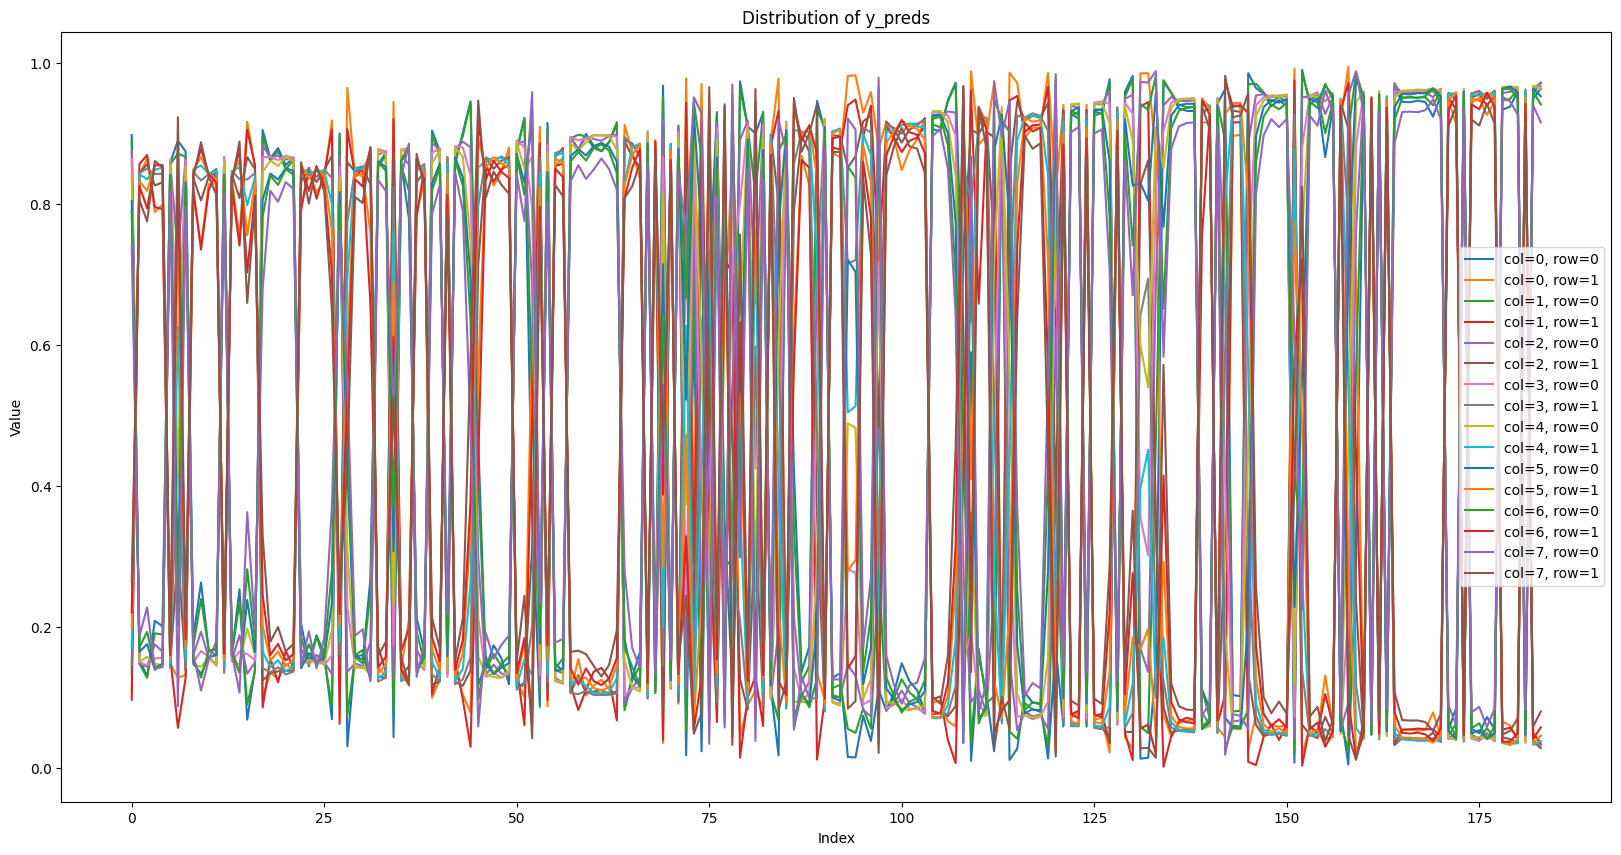

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
for col in range(y_preds.shape[1]):
    for row in range(y_preds.shape[2]):
        plt.plot(y_preds[:, col, row], label=f'col={col}, row={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


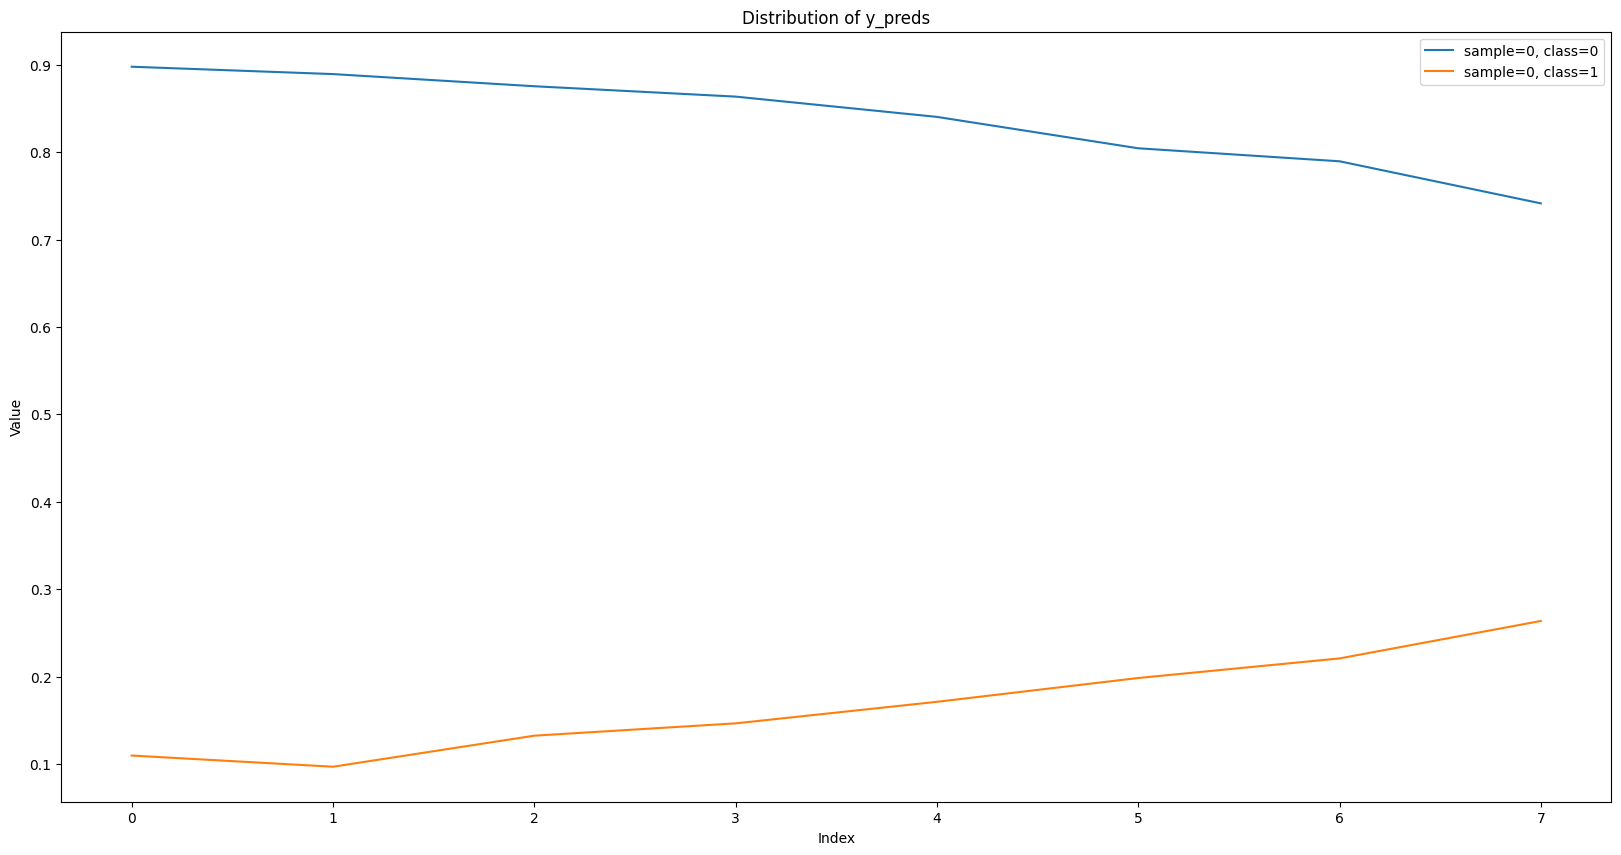

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
# for col in range(y_preds.shape[0]):
#     for row in range(y_preds.shape[2]):
for col in range(1):
    for row in range(2):
        plt.plot(y_preds[col, :, row], label=f'sample={col}, class={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

class Postprocesser:
    def __init__(self):
        pass
    
    def check_shape(self, X_train, X_test, X_newest, y_train, y_test, y_preds, reshape="False"):
        if reshape == "True":
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])
            X_newest = X_newest.reshape(X_newest.shape[0], X_newest.shape[2], X_newest.shape[1])
            y_train = y_train.reshape(y_train.shape[0], y_train.shape[2], y_train.shape[1])
            y_test = y_test.reshape(y_test.shape[0], y_test.shape[2], y_test.shape[1])
            y_preds = y_preds.reshape(y_preds.shape[0], y_preds.shape[2], y_preds.shape[1])
        return X_train, X_test, X_newest, y_train, y_test, y_preds
    
    def modify_rows(self, arr):
        for row in arr:
            # Find the first index in the row where the change occurs
            change_index = np.where(np.diff(row) != 0)[0]
            if change_index.size > 0:
                first_change_index = change_index[0] + 1
                # Set all values after the first change to the value at the change index
                row[first_change_index:] = row[first_change_index]
        return arr

    def remove_short_sequences(self, arr, x):
        """
        Remove sequences in the array that are shorter than x, considering both 0 to 1 and 1 to 0 changes.

        :param arr: The input array
        :param x: The minimum sequence length to keep
        :return: The modified array
        """
        # Identify the changes in the array
        change_indices = np.where(np.diff(arr) != 0)[0] + 1
        # Include the start and end of the array
        change_indices = np.insert(change_indices, 0, 0)
        change_indices = np.append(change_indices, len(arr))
        
        for i in range(len(change_indices) - 1):
            # Calculate the length of the sequence
            seq_length = change_indices[i+1] - change_indices[i]
            if seq_length < x:
                # Set the values of short sequences to the value preceding the sequence
                arr[change_indices[i]:change_indices[i+1]] = arr[change_indices[i] - 1]
        return arr

    def process_signals(self, y_data, dates, filter):
        max_indices = np.argmax(y_data, axis=-1)
        # max_indices = self.modify_rows(max_indices)
        flatten_max_indices = max_indices.flatten()
        if filter:
            flatten_max_indices = self.remove_short_sequences(flatten_max_indices.copy(), filter)
        signals = np.full(flatten_max_indices.shape, '', dtype=object)

        for i in range(1, len(flatten_max_indices)):
            # downward to upward
            if flatten_max_indices[i-1] == 1 and flatten_max_indices[i] == 0:
                signals[i] = 'Buy'
            # upward to downward
            elif flatten_max_indices[i-1] == 0 and flatten_max_indices[i] == 1:
                signals[i] = 'Sell'

        non_empty_signals = np.where(signals != '')[0]
        if non_empty_signals.size > 0:
            first_signal_index = non_empty_signals[0]
            last_signal_index = non_empty_signals[-1]
            signals[first_signal_index] += ' (first)'
            signals[last_signal_index] += ' (last)'

        flat_dates = dates.flatten()
        return pd.DataFrame({'Date': flat_dates, 'Signal': signals})


In [ ]:
y_preds.shape

(184, 8, 2)

In [ ]:
params['filter'] = 10

In [ ]:
postprocessor = Postprocesser()

# X_train, X_test, X_newest, y_train, y_test, y_preds = \
#     postprocessor.check_shape(X_train, X_test, X_newest, y_train, y_test, y_preds, reshape=params['model_params'][params['model_type']]['reshape'])
test_trade_signals = postprocessor.process_signals(y_test, test_dates, False)
pred_trade_signals = postprocessor.process_signals(y_preds, test_dates, params['filter'])


In [ ]:
pred_trade_signals

,Date,Signal
0,2015-03-02,
1,2015-03-03,
2,2015-03-04,
3,2015-03-05,
4,2015-03-06,
...,...,...
1467,2020-12-24,
1468,2020-12-28,
1469,2020-12-29,
1470,2020-12-30,


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix
import seaborn as sns
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from io import StringIO
import sys
from pytorchsummary import summary

class Evaluator:
    def __init__(self):
        pass

    def confusion_matrix(self, y_preds, y_test):
        # Flatten the 3D tensors for evaluation
        y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Calculate evaluation metrics
        precision = precision_score(y_test_flat, y_preds_flat, average='macro')
        recall = recall_score(y_test_flat, y_preds_flat, average='macro')
        accuracy = accuracy_score(y_test_flat, y_preds_flat)
        f1 = f1_score(y_test_flat, y_preds_flat, average='macro')

        return precision, recall, accuracy, f1
    
    def plot_confusion_matrix(self, y_test, y_preds, save_path='plots/confusion_matrix.png'):
        # Convert to class labels if necessary
        y_test = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_preds)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Confusion Matrix')

        # Calculate metrics
        precision = precision_score(y_test, y_preds, average='macro')
        recall = recall_score(y_test, y_preds, average='macro')
        accuracy = accuracy_score(y_test, y_preds)
        f1 = f1_score(y_test, y_preds, average='macro')

        # Annotate metrics on the plot
        plt.xlabel(f'Predicted\n\nAccuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nPrecision: {precision:.2f}')
        plt.ylabel(f'Actual\n\nRecall: {recall:.2f}')
        plt.savefig(save_path)
        # plt.close()
        plt.show()
        confusion_matrix_text = \
        f'''\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}\n
        '''
        return save_path, confusion_matrix_text

    def plot_training_curve(self, history, save_path='plots/training_curve.png'):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot training loss on the first subplot
        ax1.plot(history['loss'], color='tab:blue')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)

        ax2.plot(history['binary_accuracy'], color='tab:green')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')

        ax2.grid(True)

        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path

    def plot_online_training_curve(self, acc, losses, save_path='plots/online_training_curve.png'):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss on the second subplot
        ax1.plot(losses, color='tab:blue')
        ax1.set_title('Online Training Loss')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # Plot accuracy on the first subplot
        ax2.plot(acc, color='tab:red')
        ax2.set_title('Online Training Accuracy')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)

        # Adjust the layout
        plt.tight_layout()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path
    
    def remove_short_sequences(self, arr, x):
        """
        Remove sequences in the array that are shorter than x, considering both 0 to 1 and 1 to 0 changes.

        :param arr: The input array
        :param x: The minimum sequence length to keep
        :return: The modified array
        """
        # Identify the changes in the array
        change_indices = np.where(np.diff(arr) != 0)[0] + 1
        # Include the start and end of the array
        change_indices = np.insert(change_indices, 0, 0)
        change_indices = np.append(change_indices, len(arr))
        
        for i in range(len(change_indices) - 1):
            # Calculate the length of the sequence
            seq_length = change_indices[i+1] - change_indices[i]
            if seq_length < x:
                # Set the values of short sequences to the value preceding the sequence
                arr[change_indices[i]:change_indices[i+1]] = arr[change_indices[i] - 1]
        return arr
    
    def plot_predictions(self, y_test, y_preds, filter, save_path='plots/predictions.png'):
        # Convert one-hot encoded arrays to integer labels
        y_test_labels = np.argmax(y_test, axis=-1).flatten()
        y_preds_labels = np.argmax(y_preds, axis=-1).flatten()
        if filter:
            y_preds_labels = self.remove_short_sequences(y_preds_labels.copy(), filter)
        plt.figure(figsize=(32, 6))
        # Plotting y_test
        plt.plot(y_test_labels, label='y_test')

        # Plotting y_preds
        plt.plot(y_preds_labels, label='y_preds')

        # Adding labels and legend
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend(fontsize=20)
        plt.savefig(save_path)
        # Display the plot
        plt.show()
        return save_path
    
    def plot_trading_signals(self, data, trade_signals, x_start=0, x_stop=-1, save_path='plots/trading_details_kbar.png'):
        stock_data = data[['Open', 'High', 'Low', 'Close']].loc[data.index.isin(trade_signals['Date'])]
        stock_data['pred_signal'] = trade_signals['Signal'].values
    
        fig, ax = plt.subplots(figsize=(32, 6))
        for i in stock_data['pred_signal'].index[x_start:x_stop]:
            self._kbar(stock_data['Open'].loc[i], stock_data['Close'].loc[i], stock_data['High'].loc[i], stock_data['Low'].loc[i], i, ax)

        self._plot_signals(trade_signals, stock_data, x_start, x_stop, ax)
        ax.set_title(f'Trading Details, from {stock_data.index[x_start].date()} to {stock_data.index[x_stop].date()}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.set_xticks(stock_data.index[x_start:x_stop])
        # ax.set_xticklabels(stock_data.index[x_start:x_stop].strftime('%Y-%m-%d'), rotation=30, ha='right', fontsize=6)
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_fontsize(6)
        plt.grid()
        plt.legend()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path

    def _kbar(self, open, close, high, low, pos, ax): # for US stocks
        if close > open: 
            color='green'   # rise               
            height=close - open   
            bottom=open             
        else:                         
            color='red'     # fall            
            height=open - close   
            bottom=close             
        ax.bar(pos, height=height,bottom=bottom, width=0.6, color=color)
        ax.vlines(pos, high, low, color=color)

    def _plot_signals(self, trade_signals, stock_data, x_start, x_stop, ax):
        buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
        for i in buy_signals['Date']:
            if i in stock_data.index: 
                ax.scatter(i, stock_data.loc[i, 'Low'] - 50, marker='^', color='green', s=100)

        sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
        for i in sell_signals['Date']:
            if i in stock_data.index:
                ax.scatter(i, stock_data.loc[i, 'High'] + 50, marker='v', color='red', s=100)

    def find_closest_date(self, pred_trade_signals, test_trade_signals):
        # Filtering and processing signals
        pred_df_filtered = pred_trade_signals[pred_trade_signals['Signal'].notna() & (pred_trade_signals['Signal'] != '')]
        test_df_filtered = test_trade_signals[test_trade_signals['Signal'].notna() & (test_trade_signals['Signal'] != '')]

        for index in pred_df_filtered.index:
            if '(first)' in pred_df_filtered['Signal'].loc[index] or '(last)' in pred_df_filtered['Signal'].loc[index]:
                pred_df_filtered.loc[index, 'Signal'] = pred_df_filtered['Signal'].loc[index].split()[0]
        for index in test_df_filtered.index:
            if '(first)' in test_df_filtered['Signal'].loc[index] or '(last)' in test_df_filtered['Signal'].loc[index]:
                test_df_filtered.loc[index, 'Signal'] = test_df_filtered['Signal'].loc[index].split()[0]
                
        # Creating a new DataFrame to store the results
        pred_days_difference_results = pred_df_filtered.copy()
        pred_days_difference_results['ClosestDateInTest'] = pd.NaT
        pred_days_difference_results['DaysDifference'] = pd.NA
        
        # Iterating through each row in pred_days_difference_results to find the closest date and days difference
        for index, row in pred_days_difference_results.iterrows():
            signal, pred_date = row['Signal'], row['Date']
            same_signal_df = test_df_filtered[test_df_filtered['Signal'] == signal].copy()

            if not same_signal_df.empty:
                same_signal_df['DateDifference'] = (same_signal_df['Date'] - pred_date)
                closest_date = same_signal_df.loc[same_signal_df['DateDifference'].abs().idxmin()]
                pred_days_difference_results.at[index, 'ClosestDateInTest'] = closest_date['Date']
                pred_days_difference_results.at[index, 'DaysDifference'] = closest_date['DateDifference'].days

        return pred_days_difference_results
    
    def _plot_days_difference_bar_chart(self, pred_days_difference_results, save_path='plots/pred_days_difference_bar_chart.png'):
        # Create bar plot
        plt.figure(figsize=(14, 6))
        plt.bar(range(len(pred_days_difference_results)), pred_days_difference_results['DaysDifference'], color='blue', alpha=0.7)
        plt.title('Bar plot of pred_days_difference_results')
        plt.xlabel('Index')
        plt.ylabel('Difference Value')
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.savefig(save_path)
        plt.show()
        return save_path
        
    def perform_backtesting(self, stock_data, trade_signals):
        buffer = StringIO()
        sys.stdout = buffer

        # Initialize cerebro engine
        cerebro = bt.Cerebro()
        # Create a data feed from stock data
        data_feed = bt.feeds.PandasData(dataname=stock_data)
        # Add data feed to cerebro
        cerebro.adddata(data_feed)
        # Define and add strategy
        class SignalStrategy(bt.Strategy):
            def __init__(self):
                # Map dates to signals for quick lookup

                self.signal_dict = \
                    dict((pd.Timestamp(date).to_pydatetime().date(), signal)
                                        for date, signal in zip(trade_signals['Date'], 
                                                                trade_signals['Signal']))
            def log(self, txt, dt=None):
                # Logging function for this strategy
                dt = dt or self.datas[0].datetime.date(0)
                print(f'{dt.isoformat()}, {txt}')
                
            def next(self):
                # Get the current date
                current_date = self.datas[0].datetime.date(0)
                # Check if there's a signal for this date
                signal = self.signal_dict.get(current_date)
                if signal == 'Buy (first)' or signal == 'Buy (last)':
                    # Buy logic
                    self.buy(size=1)
                    self.log("SINGLE BUY EXECUTED")
                elif signal == 'Sell (first)' or signal == 'Sell (last)':
                    # Sell logic
                    self.sell(size=1)
                    self.log("SINGLE SELL EXECUTED")
                elif signal == 'Buy':
                    # Buy logic
                    self.buy(size=2)
                    self.log("DOUBLE BUY EXECUTED")  
                elif signal == 'Sell':
                    # Sell logic
                    self.sell(size=2)
                    self.log("DOUBLE SELL EXECUTED") 

            def notify_order(self, order):
                if order.status in [order.Completed]:
                    cash = self.broker.getcash()
                    value = self.broker.getvalue() 
                    if order.isbuy():
                        self.log(f'BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Commission: {order.executed.comm}, Cash: {cash}, Value: {value}')
                    elif order.issell():
                        self.log(f'SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Commission: {order.executed.comm}, Cash: {cash}, Value: {value}')
        
        # Add strategy to cerebro
        cerebro.addstrategy(SignalStrategy)
        # Set initial cash, commission, etc.
        cerebro.broker.setcash(10000.0)
        cerebro.broker.setcommission(commission=0.001)
        # You can add more code here to analyze the results
        # Add analyzers to cerebro
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
        # Run the backtest
        strategies = cerebro.run()
        backtesting_report = dict()
        # Extracting and displaying results
        strategy = strategies[0]
        backtesting_report['sharpe_ratio'] = strategy.analyzers.sharpe_ratio.get_analysis()
        backtesting_report['drawdown'] = strategy.analyzers.drawdown.get_analysis()
        backtesting_report['trade_analyzer'] = strategy.analyzers.trade_analyzer.get_analysis()
        backtesting_report['final_value'] = cerebro.broker.getvalue()
        backtesting_report['pnl'] = backtesting_report['final_value'] - cerebro.broker.startingcash
        backtesting_report['pnl_pct'] = backtesting_report['pnl'] / cerebro.broker.startingcash * 100.0
        backtesting_report['total_return'] = backtesting_report['final_value'] / cerebro.broker.startingcash

        # Plotting the results
        sys.stdout = sys.__stdout__
        trade_summary = buffer.getvalue()
        buffer.close()
        # img = cerebro.plot(style='candlestick', iplot=False, volume=False, savefig=True)
        # img[0][0].savefig(f'plots/backtesting_kbar.png')
        return strategies, backtesting_report, trade_summary
    
    def generate_model_summary(self, model):
        # Capture the summary output
        # buffer = StringIO()
        # sys.stdout = buffer
        # summary(model=model, input_size=(1, 19, 32))
        # sys.stdout = sys.__stdout__
        # model_summary = buffer.getvalue()
        # buffer.close()
        total = sum([param.nelement() for param in model.parameters()])
        model_summary = f'{model}, \nNumber of parameter: {total}'
        return model_summary

    # TODO:　fix the plot_trading_signals bugs
    def _compile_and_save_report(self, model_summary, training_report, online_training_report, 
                                 confusion_matrix, confusion_matrix_text, 
                                 pred_trade_signals_plot_save_path, test_trade_signals_plot_save_path, predictions_save_path, filtered_predictions_save_path,
                                 pred_days_difference_results, pred_days_difference_bar_chart_save_path, 
                                 backtesting_report, trade_summary, save_path='report.html'):
        # Compile the report. This can be done using a HTML generator.
        backtesting_report_table = pd.DataFrame()
        backtesting_report_table['sharpe_ratio'] = [backtesting_report['sharpe_ratio']['sharperatio']]
        # backtesting_report_table['drawdown'] = [backtesting_report['drawdown']['max']['drawdown']]
        backtesting_report_table['initial_value'] = [10000.0]
        backtesting_report_table['final_value'] = [backtesting_report['final_value']]
        backtesting_report_table['total_return'] = [backtesting_report['total_return']]
        backtesting_report_table['final_value'] = [backtesting_report['final_value']]
        backtesting_report = backtesting_report_table.to_html()
        pred_days_difference_abs_mean = pred_days_difference_results['DaysDifference'].abs().mean()
        pred_days_difference_results = pred_days_difference_results.to_html()
        
        report = f'''
        <html>
            <head>
                <title>Stock Price Prediction Report</title>
            </head>
            <body>
                <h1>Stock Price Prediction Report</h1>
                <h2>Model Summary</h2>
                <pre>{model_summary}</pre>
                <h2>Training Report</h2>
                <img src="{training_report}" />
                <h2>Online Training Report</h2>
                <img src="{online_training_report}" />
                <h2>Confusion Matrix</h2>
                <pre>{confusion_matrix_text}</pre>
                <img src="{confusion_matrix}" />
                <h2>Predictions Compared With Actual Signals</h2>
                <img src="{predictions_save_path}" />
                <h2>Filtered Predictions Compared With Actual Signals</h2>
                <img src="{filtered_predictions_save_path}" />
                <h2>Predict Trading Signals Difference Bar chart</h2>
                <img src="{pred_days_difference_bar_chart_save_path}" />
                <h2>Predict Trading Signals Difference Details</h2>
                <pre>Average Difference: {pred_days_difference_abs_mean}</pre>
                <pre>{pred_days_difference_results}</pre>
                <h2>Predict Trading Details</h2>
                <img src="{pred_trade_signals_plot_save_path}" />
                <h2>Actual Trading Details</h2>
                <img src="{test_trade_signals_plot_save_path}" />
                <h2>Trade Summary</h2>
                <pre>{backtesting_report}</pre>
                <h2>Trade Details</h2>
                <pre>{trade_summary}</pre>
            </body>
        </html>
        '''

        # Save the report to a file
        with open(save_path, 'w') as file:
            file.write(report)

    def generate_report(self, model, y_test, y_preds, history, 
                        online_training_acc, online_training_losses,
                        data, pred_trade_signals, test_trade_signals, x_start=0, x_stop=-1):
        model_summary = self.generate_model_summary(model)
        if history:
            training_report = self.plot_training_curve(history, save_path='plots/training_curve.png')
        else:
            training_report = ''
        online_training_report = self.plot_online_training_curve(online_training_acc, 
                                        online_training_losses, save_path='plots/online_training_curve.png')
        confusion_matrix, confusion_matrix_text = self.plot_confusion_matrix(y_test, y_preds, save_path='plots/confusion_matrix.png')
        predictions_save_path = self.plot_predictions(y_test, y_preds, False, save_path='plots/predictions.png')
        filtered_predictions_save_path = self.plot_predictions(y_test, y_preds, filter=params['filter'], save_path='plots/filtered_predictions.png')
        pred_trade_signals_plot_save_path = self.plot_trading_signals(data, pred_trade_signals, x_start, x_stop, save_path='plots/pred_trade_signals_details_kbar.png')
        test_trade_signals_plot_save_path = self.plot_trading_signals(data, test_trade_signals, x_start, x_stop, save_path='plots/test_trade_signals_details_kbar.png')
        pred_days_difference_results = self.find_closest_date(pred_trade_signals, test_trade_signals)
        pred_days_difference_bar_chart_save_path = self._plot_days_difference_bar_chart(pred_days_difference_results, save_path='plots/pred_days_difference_bar_chart.png')
        backtest_results, backtesting_report, trade_summary = self.perform_backtesting(data, pred_trade_signals)
        self._compile_and_save_report(model_summary, training_report, online_training_report, confusion_matrix, 
                                      confusion_matrix_text, pred_trade_signals_plot_save_path, test_trade_signals_plot_save_path, predictions_save_path, filtered_predictions_save_path,
                                      pred_days_difference_results, pred_days_difference_bar_chart_save_path, backtesting_report, trade_summary, save_path='report.html')


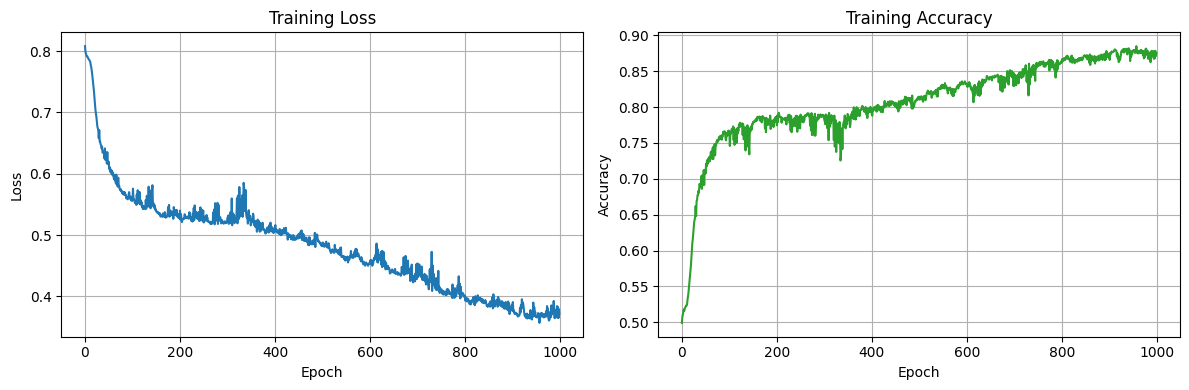

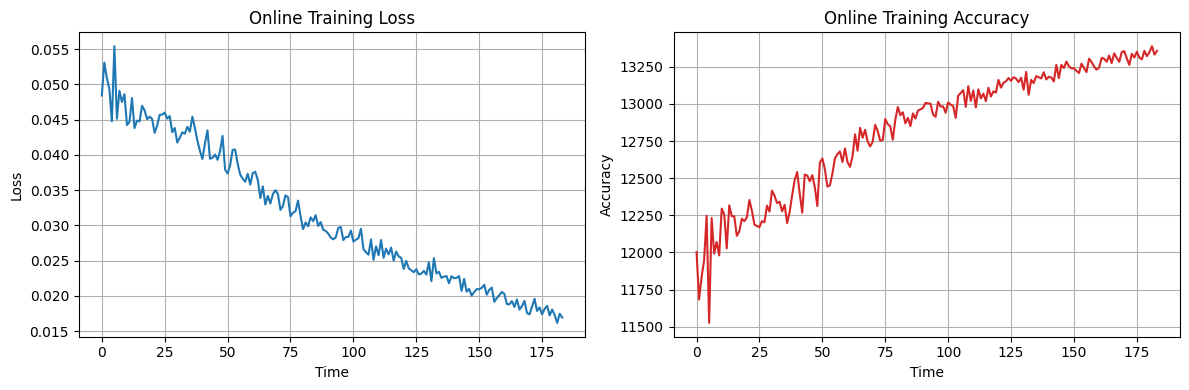

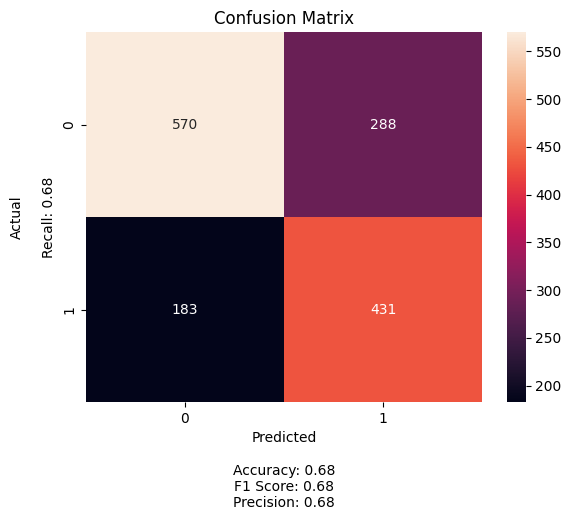

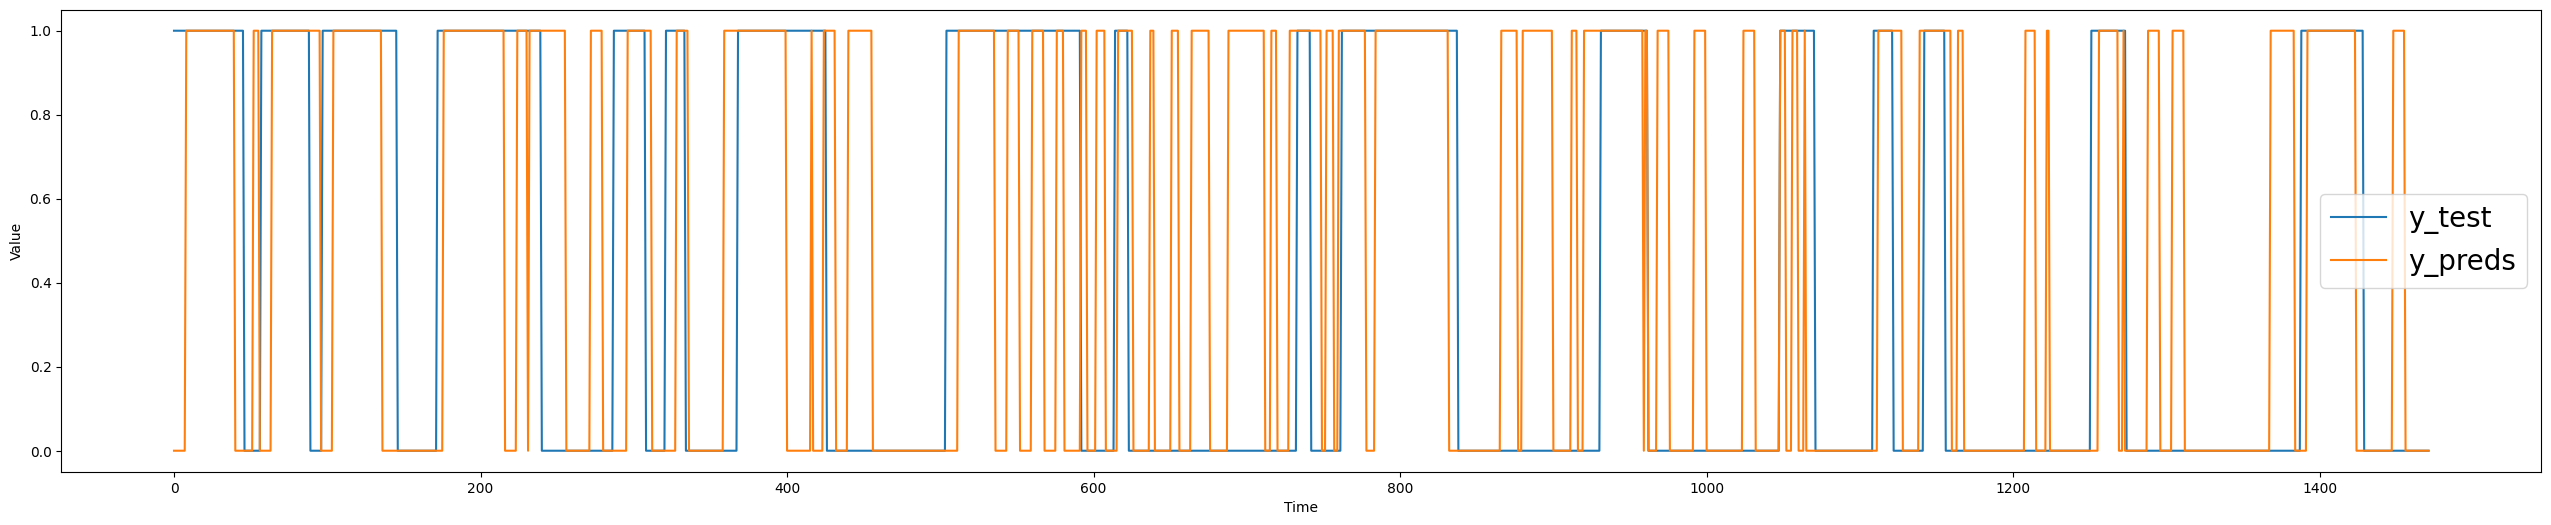

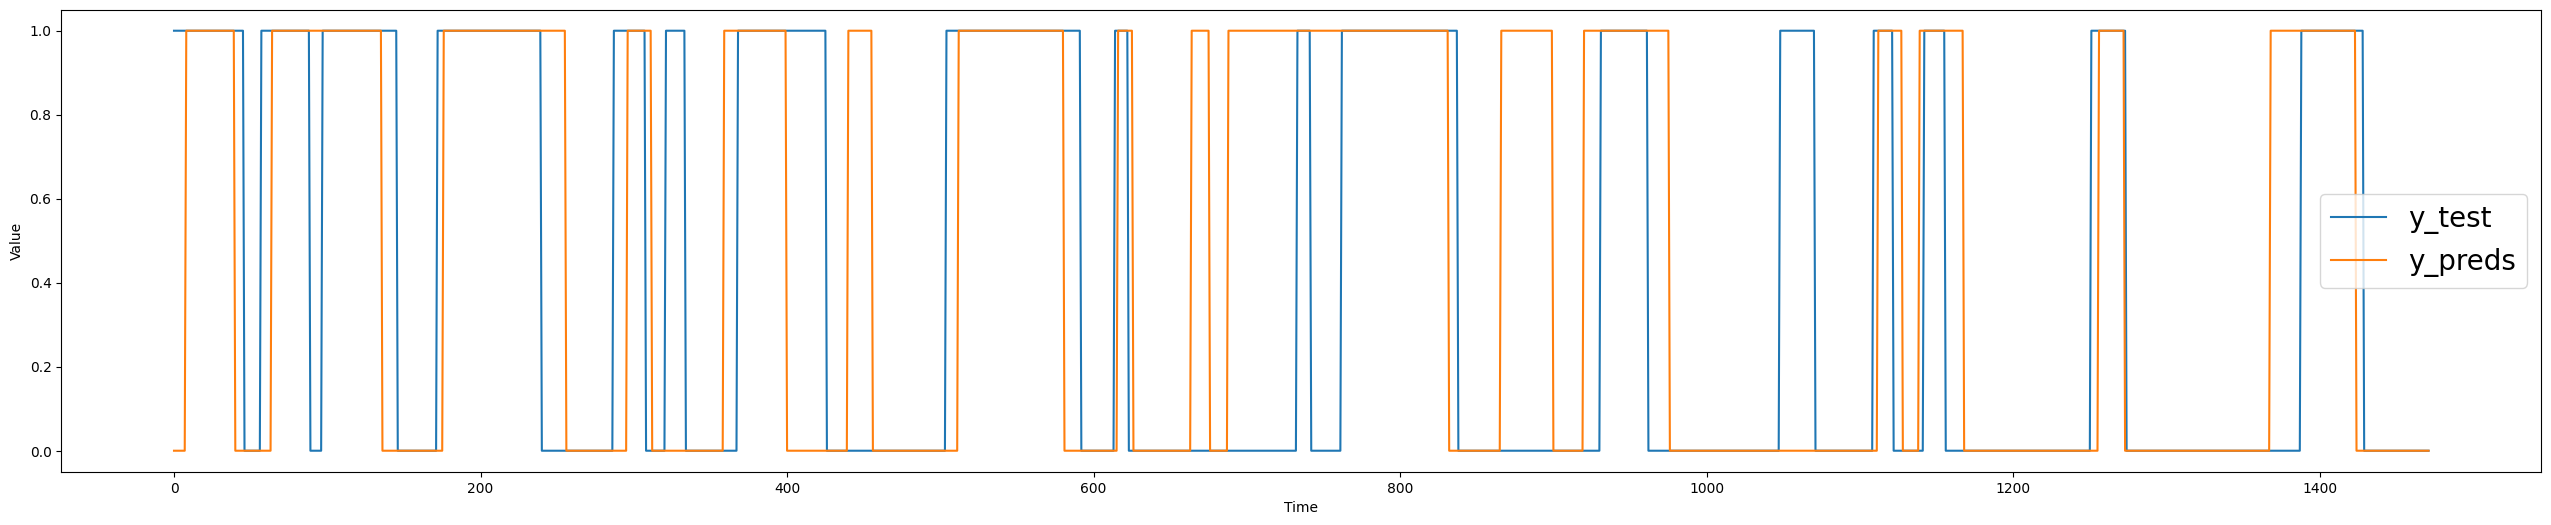

C:\Users\e4903\AppData\Local\Temp\ipykernel_8952\3820963109.py:192: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
C:\Users\e4903\AppData\Local\Temp\ipykernel_8952\3820963109.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


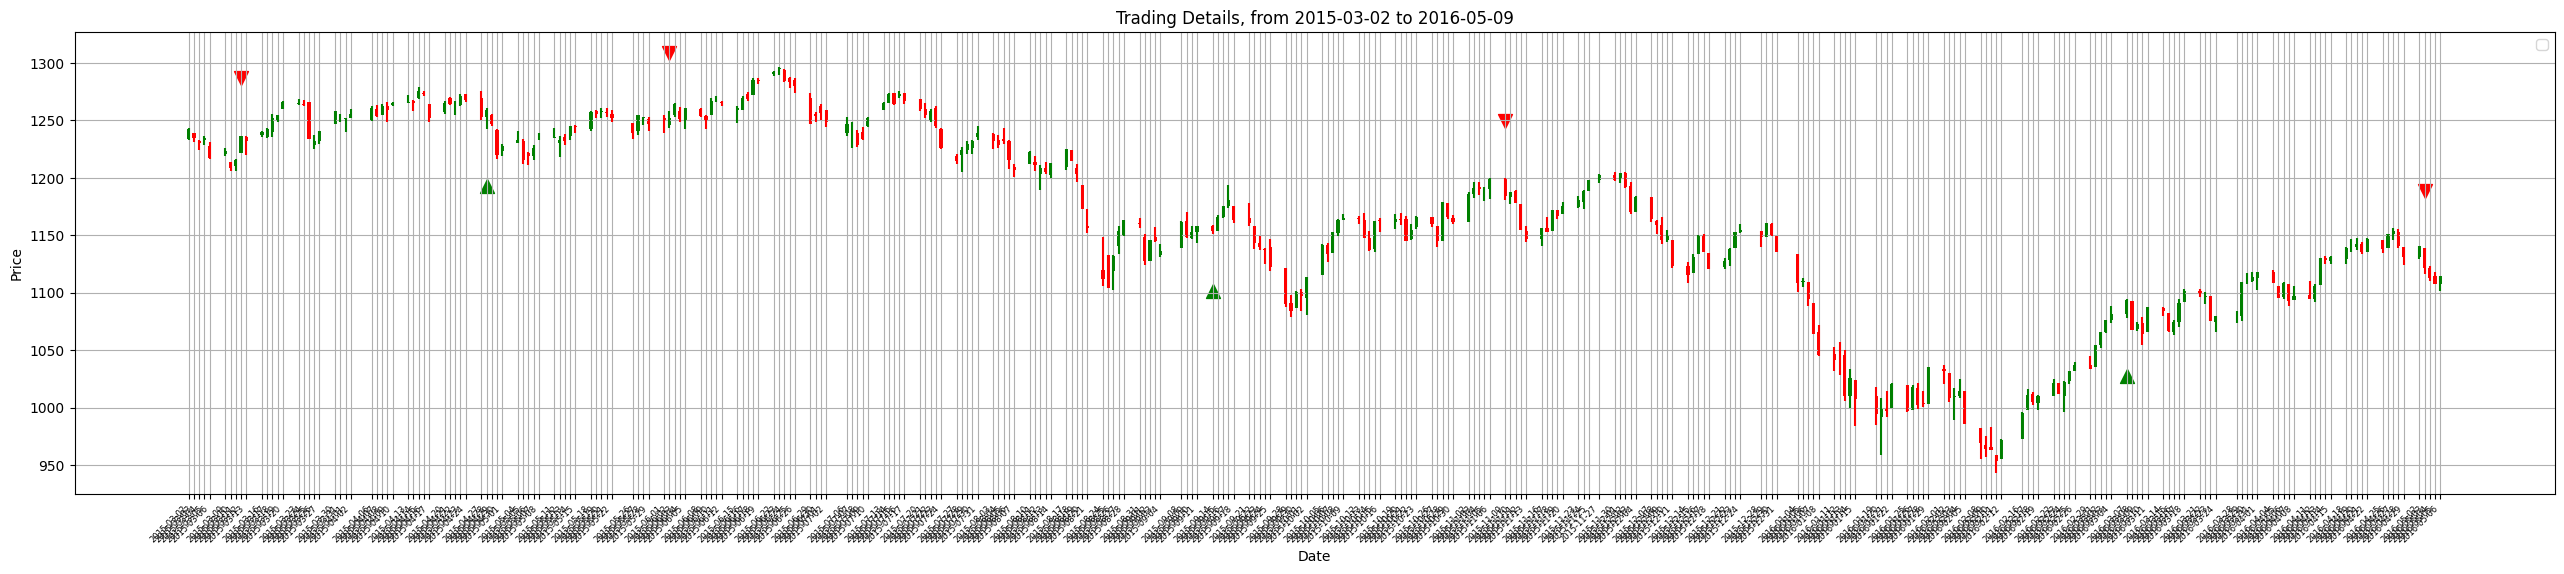

C:\Users\e4903\AppData\Local\Temp\ipykernel_8952\3820963109.py:192: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
C:\Users\e4903\AppData\Local\Temp\ipykernel_8952\3820963109.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


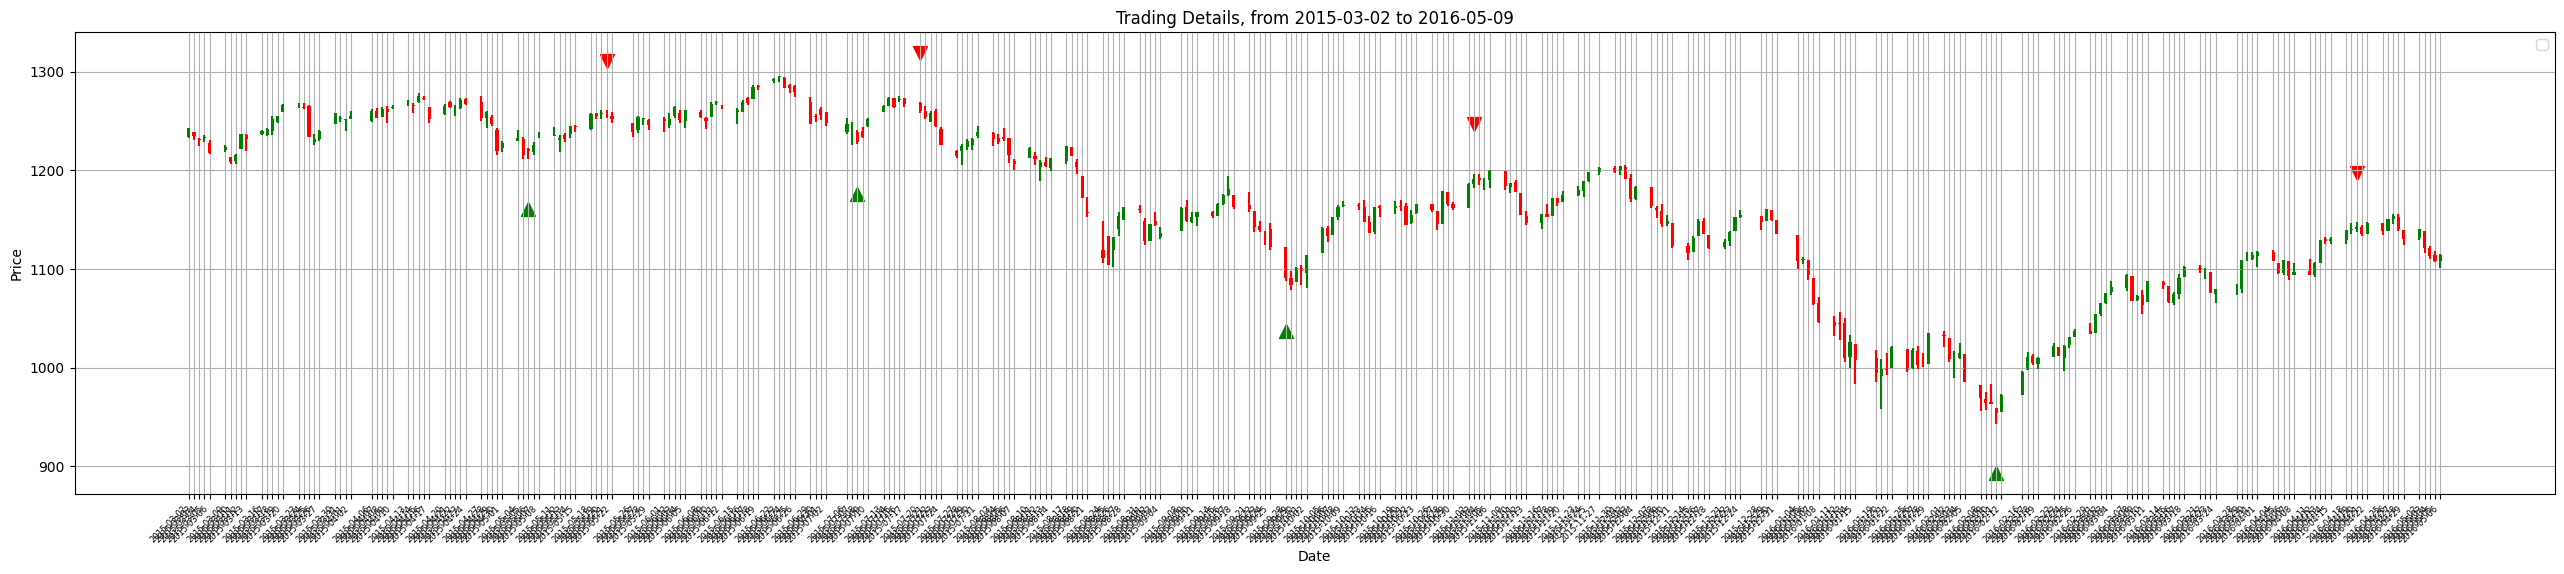

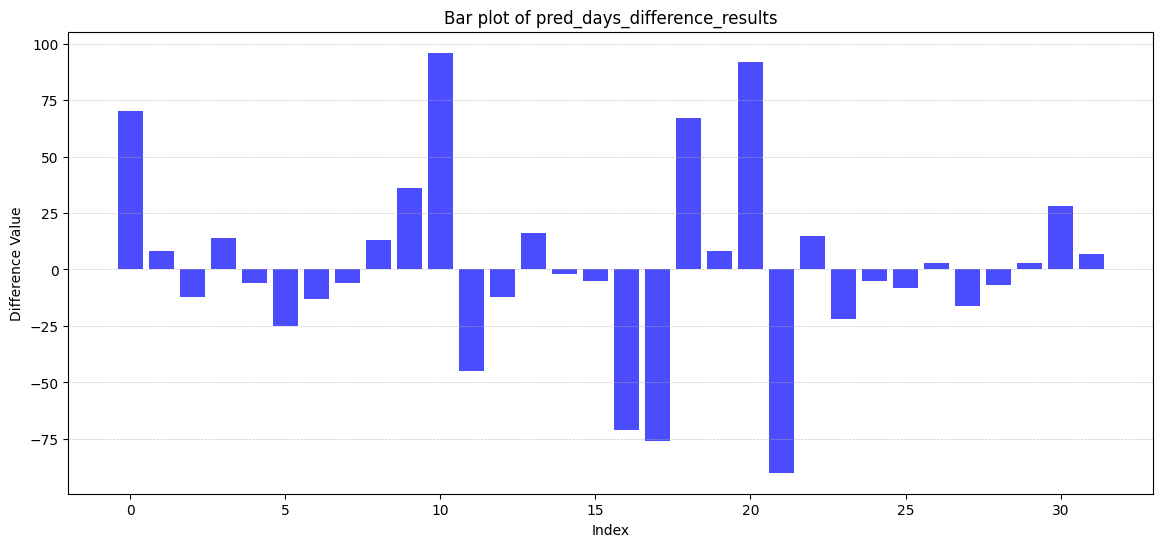

In [ ]:
evaluator = Evaluator()
total = sum([param.nelement() for param in model.parameters()])
model_summary = f'{model}, \nNumber of parameter: {total}'
print(model_summary)
evaluator.generate_report(model, y_test, y_preds, history, 
                        online_training_acc, online_training_losses,
                        data, pred_trade_signals, test_trade_signals, x_start=0, x_stop=300)
